In [1]:
import re
import os
import gc
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

tqdm.pandas()
logging.basicConfig(level=logging.DEBUG)

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
SENTIMENT_COLUMN = 'target'
TEXT_COLUMN = 'text'
RAW_TEXT_COLUMN = 'raw_text'

In [3]:
def read_files(path):
    train_pos_files = os.listdir(path)
    raw_text = []
    for filename in train_pos_files:
        fb = open(path+filename,'r')
        raw_text.append(fb.readline())
        fb.close()  
    return raw_text

In [4]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
def normalize(words):
    word_list = []
    for word in words:
        """Remove non-ASCII characters from list of tokenized words"""
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        """Convert all characters to lowercase from list of tokenized words"""
        new_word = new_word.lower()
        """Remove punctuation except for "?" and "!" from list of tokenized words"""
        if contraction_mapping.__contains__(new_word):
            new_word = contraction_mapping[new_word]
        new_word = re.sub(r'[^\w\s!?]', '', new_word)
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        new_word = lemmatizer.lemmatize(new_word, pos='v')
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        if new_word.isdigit():
            new_word = 'digit'
        if new_word != '':
            word_list.append(new_word)
    return word_list

In [5]:
# read all train data
train_pos = read_files('./aclImdb/train/pos/')
train_neg = read_files('./aclImdb/train/neg/')
raw_train_text = train_pos + train_neg
train_label = [1] * len(train_pos) + [0] * len(train_neg)
raw_train_text, train_label = shuffle(raw_train_text, train_label, random_state=0)

# read all test data
test_pos = read_files('./aclImdb/test/pos/')
test_neg = read_files('./aclImdb/test/neg/')
raw_test_text = test_pos + test_neg
test_label = [1] * len(test_pos) + [0] * len(test_neg)
raw_test_text, test_label = shuffle(raw_test_text, test_label, random_state=0)

raw_corpus_text = raw_train_text + raw_test_text

In [6]:
from nltk.stem import WordNetLemmatizer
from tokenizer import tokenize
import re, unicodedata, inflect
train_text = []
for each in raw_train_text:
    tmp = each.replace('-', ' ').replace('<br />',"")
    train_text.append("".join(word + ' ' for word in normalize([word.txt for word in tokenize(tmp) if word.txt != None])).strip())
test_text = []
for each in raw_test_text:
    tmp = each.replace('-', ' ').replace('<br />',"")
    test_text.append("".join(word + ' ' for word in normalize([word.txt for word in tokenize(tmp) if word.txt != None])).strip())
processed_corpus_text = train_text + test_text

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/jianhenghou/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/jianhenghou/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


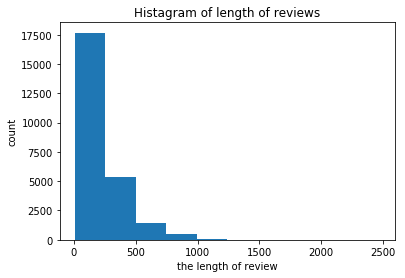

In [7]:
count = [len(review.split()) for review in raw_train_text]
plt.title('Histagram of length of reviews')
plt.xlabel('the length of review')
plt.ylabel('count')
plt.hist(count)
plt.show()

In [8]:
MAX_SEQUENCE_LEN = 512
MAX_FEATURES = 100000

In [9]:
"""
Load data
"""

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

train = pd.DataFrame(list(zip(raw_train_text,train_text, train_label)), columns =[RAW_TEXT_COLUMN,TEXT_COLUMN, SENTIMENT_COLUMN])
test = pd.DataFrame(list(zip(raw_test_text,test_text, test_label)), columns =[RAW_TEXT_COLUMN,TEXT_COLUMN, SENTIMENT_COLUMN])
train_label = train[SENTIMENT_COLUMN]

Using TensorFlow backend.


In [13]:
"""
Fit tokenizer
"""

logging.info("Fitting Tokenizer")

tokenizer = Tokenizer(num_words=MAX_FEATURES, lower=True)
# Updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(list(train[TEXT_COLUMN]) + list(test[TEXT_COLUMN]))

logging.info("Beginning process train text")
train_text = tokenizer.texts_to_sequences(list(train[TEXT_COLUMN]))
train_text = pad_sequences(train_text, maxlen=MAX_SEQUENCE_LEN)

logging.info("Beginning process test text")
test_text = tokenizer.texts_to_sequences(list(test[TEXT_COLUMN]))
test_text = pad_sequences(test_text, maxlen=MAX_SEQUENCE_LEN)

INFO:root:Fitting Tokenizer
INFO:root:Beginning process train text


In [14]:
word_index = tokenizer.word_index
del tokenizer
gc.collect()

0

In [15]:
"""
Get word Embedding
"""

EMB_PATH = "skipgram_model_IMDB.vec"
EMBEDDING_DIM = 300

def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(embed_dir=EMB_PATH):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in tqdm(open(embed_dir)))
    return embedding_index

def build_matrix(word_index, embeddings_index):
    embedding_matrix = np.zeros((len(word_index) + 1,EMBEDDING_DIM))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embeddings_index[word]
        except:
            embedding_matrix[i] = embeddings_index["unknown"]
    return embedding_matrix

In [16]:
embeddings_index = load_embeddings()
embedding_matrix = build_matrix(word_index, embeddings_index)
del embeddings_index
gc.collect()

76832it [00:05, 14635.25it/s]


0

In [20]:
"""
Attention model
"""


from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight((input_shape[-1],),
                                 initializer = self.init,
                                 name = '{}_W'.format(self.name),
                                 regularizer = self.W_regularizer,
                                 constraint = self.W_constraint)
        self.features_dim = input_shape[-1]
        
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer = 'zero',
                                     name = '{}_b'.format(self.name),
                                     regularizer = self.b_regularizer,
                                     constraint = self.b_constraint)
        else:
            self.b = None
        
        self.built = True
    
    def compute_mask(self, input, input_mask=None):
        return None
    
    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        
        e_ij = K.reshape(K.dot(
                            K.reshape(x, (-1, features_dim)),
                            K.reshape(self.W, (features_dim, 1))
                    ), (-1, step_dim))
        if self.bias:
            e_ij += self.b
        
        e_ij = K.tanh(e_ij)
        
        a = K.exp(e_ij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(),
                    K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

In [21]:
"""
Model builder
"""

from keras.layers import SpatialDropout1D, Bidirectional, Dense, LSTM
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D
from keras.layers import concatenate
from keras.layers import Input, Embedding, Concatenate
from keras.models import Model
from keras.optimizers import Adam

def build_model(verbose = False, compile = True):
    sequence_input = Input(shape=(MAX_SEQUENCE_LEN,), dtype='int32')
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LEN,
                                trainable=False)
    
    x = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(x)        
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    
    attention = Attention(MAX_SEQUENCE_LEN)(x)
    conv = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    avg_pool1 = GlobalAveragePooling1D()(conv)
    max_pool1 = GlobalMaxPooling1D()(conv)
    
    # version2
    avg_pool2 = GlobalAveragePooling1D()(x)
    max_pool2 = GlobalMaxPooling1D()(x)

    
    x = concatenate([attention, 
                     avg_pool1, max_pool1, 
                     avg_pool2, max_pool2])
    preds = Dense(1, activation='sigmoid')(x)
    
    model = Model(sequence_input, preds)
    if verbose:
        model.summary()
    if compile:
        model.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.005),
                      metrics=['acc'])
    return model

In [22]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 512, 300)     30914400    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 512, 300)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 512, 128)     186880      spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
conv1d_1 (

In [23]:
"""
Training Session
"""
from keras import backend as K
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping, ModelCheckpoint


BATCH_SIZE = 1024
NUM_EPOCHS = 100
FOLDER_NUM = 5

splits = list(KFold(n_splits=FOLDER_NUM).split(train_text, train_label))

test_preds = np.zeros((test_text.shape[0]))
folders = [i for i in range(FOLDER_NUM)]

for folder in folders:
    K.clear_session()
    train_index, validate_index = splits[folder]
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    model = build_model()
    model.fit(x = train_text[train_index],
              y = train_label[train_index],
              batch_size = BATCH_SIZE,
              epochs = NUM_EPOCHS,
              validation_data = (train_text[validate_index],
                                 train_label[validate_index]),
              callbacks = [es])
    test_preds += model.predict(test_text)[:, 0]
test_preds /= 5

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 249s 12ms/step - loss: 0.6908 - acc: 0.5615 - val_loss: 0.6147 - val_acc: 0.7346
Epoch 2/100
20000/20000 [==============================] - 222s 11ms/step - loss: 0.4891 - acc: 0.7897 - val_loss: 0.3699 - val_acc: 0.8354
Epoch 3/100
20000/20000 [==============================] - 196s 10ms/step - loss: 0.3728 - acc: 0.8328 - val_loss: 0.3338 - val_acc: 0.8558
Epoch 4/100
20000/20000 [==============================] - 197s 10ms/step - loss: 0.3363 - acc: 0.8541 - val_loss: 0.3093 - val_acc: 0.8698
Epoch 5/100
20000/20000 [==============================] - 202s 10ms/step - loss: 0.3118 - acc: 0.8672 - val_loss: 0.2910 - val_acc: 0.8780
Epoch 6/100
20000/20000 [==============================] - 211s 11ms/step - loss: 0.2810 - acc: 0.8806 - val_loss: 0.2782 - val_acc: 0.8856
Epoch 7/100
20000/20000 [==============================] - 202s 10ms/step - loss: 0.2596 - acc: 0.8946 - val_lo

In [26]:
test_predect = [1 if each > 0.5 else 0 for each in test_preds ]
print("==========Model Evalucation=========")
print(classification_report(test_label, test_predect))
print("============Test Accuracy===========")
print("acc:", balanced_accuracy_score(test_label, test_predect))

==========Model Evalucation=========
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     12500
           1       0.91      0.93      0.92     12500

   micro avg       0.92      0.92      0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000

============Test Accuracy===========
acc: 0.91684
